# Laboratorio 6 - Data Science

* Mónica Salvatierra 22249
* Derek Arreaga 22537

Link del repositorio: https://github.com/alee2602/LAB6-DS



**Importación de Librerías**

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense, Concatenate, SpatialDropout1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

import numpy as np
from collections import Counter



### **Importación de Datos**

In [3]:
print('Cargando los datos...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=50000)

Cargando los datos...


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

In [5]:
y_train[0]

1

In [31]:
# Promedio de largo de reseñas
total_length = 0
for x in X_train:
    total_length += len(x)
print(f'Promedio de largo de reseñas: {total_length/len(X_train)}')

# Reseña más corta
min_len = len(X_train[0])
for x in X_train:
    if len(x) < min_len:
        min_len = len(x)
print(f'Largo de reseña más corta: {min_len}')

Promedio de largo de reseñas: 80.0
Largo de reseña más corta: 80


### **Preprocesamiento**

Limitar reseñas para lograr una longitud uniforme

In [6]:
maxlen = 80
X_train = sequence.pad_sequences(X_train, maxlen = maxlen)
X_test = sequence.pad_sequences(X_test, maxlen = maxlen)

Extracción de ``features`` adicionales:
* Longitud de la crítica
* Proporción de palabras positivas/negativas

In [28]:

# Obtener el diccionario de palabras de IMDB
word_index = imdb.get_word_index()

# Diccionarios de palabras positivas y negativas (puedes expandirlos)
positive_words = {'good', 'great', 'awesome', 'excellent', 'fantastic', 'wonderful', 'love', 'amazing', 'brilliant', 'enjoyable'}
negative_words = {'bad', 'terrible', 'awful', 'horrible', 'disappointing', 'poor', 'hate', 'worst', 'boring', 'dreadful', 'fuck', 'shit', 'idiot', 'stupid', 'mediocre', 'boring', 'bored', 'asleep', 'waste', 'senseless', 'suck', 'sucks'}

# Mapear palabras positivas/negativas a sus índices
positive_indices = {word_index.get(word) + 3 for word in positive_words if word_index.get(word) is not None}
negative_indices = {word_index.get(word) + 3 for word in negative_words if word_index.get(word) is not None}

# Función para extraer características de una reseña codificada
def extract_features_from_encoded(encoded_reviews):
    features = []
    for review in encoded_reviews:
        # Filtrar tokens no nulos (ignorar padding)
        valid_tokens = [token for token in review if token > 0]
        
        review_length = len(valid_tokens)
        
        #Proporción de palabras positivas y negativas
        token_counts = Counter(valid_tokens)
        pos_count = sum(token_counts[idx] for idx in positive_indices if idx in token_counts)
        neg_count = sum(token_counts[idx] for idx in negative_indices if idx in token_counts)
        total_tokens = review_length if review_length > 0 else 1  
        pos_ratio = pos_count / total_tokens
        neg_ratio = neg_count / total_tokens
        
        unique_tokens = len(set(valid_tokens))
        
        repeated_tokens = sum(count for count in token_counts.values() if count > 1)
        repeat_ratio = repeated_tokens / total_tokens if total_tokens > 0 else 0
        
        rare_threshold = 50000 // 2  
        rare_count = sum(1 for token in valid_tokens if token > rare_threshold)
        rare_ratio = rare_count / total_tokens if total_tokens > 0 else 0
        
        features.append({
            'length': review_length,
            'positive_ratio': pos_ratio,
            'negative_ratio': neg_ratio,
            'unique_tokens': unique_tokens,
            'repeat_ratio': repeat_ratio,
            'rare_ratio': rare_ratio
        })
    
    return features

# Extraer características para el conjunto de entrenamiento
print('Extrayendo características de los datos codificados...')
train_features = extract_features_from_encoded(X_train)

# Convertir a un array
feature_names = ['length', 'positive_ratio', 'negative_ratio', 'unique_tokens', 'repeat_ratio', 'rare_ratio']
train_features_array = np.array([[f[name] for name in feature_names] for f in train_features])
print('Características extraídas correctamente.')

Extrayendo características de los datos codificados...
Características extraídas correctamente.


Mostrar las careacterísticas de la primera reseña

In [8]:
print(train_features[0])

if y_train[0] == 1:
    print('La reseña es positiva.')
else:
    print('La reseña es negativa.')

{'length': 80, 'positive_ratio': 0.025, 'negative_ratio': 0.0, 'unique_tokens': 58, 'repeat_ratio': 0.4375, 'rare_ratio': 0.0125}
La reseña es positiva.


Estadísticas generales de las nuevas ``features``:

In [9]:

for i, name in enumerate(feature_names):
    print(f'{name}: media={np.mean(train_features_array[:, i]):.4f}, std={np.std(train_features_array[:, i]):.4f}')

# Porcentaje de reseñas positivas y negativas
positive_count = sum(y_train)
negative_count = len(y_train) - positive_count
print(f'Procentaje de reseñas positivas: {positive_count/len(y_train)*100:.2f}%')
print(f'Procentaje de reseñas negativas: {negative_count/len(y_train)*100:.2f}%')

length: media=78.3894, std=6.7216
positive_ratio: media=0.0084, std=0.0121
negative_ratio: media=0.0056, std=0.0112
unique_tokens: media=60.2248, std=6.2032
repeat_ratio: media=0.3679, std=0.0811
rare_ratio: media=0.0122, std=0.0155
Procentaje de reseñas positivas: 50.00%
Procentaje de reseñas negativas: 50.00%


El vector de features captura señales globales del documento que complementan lo que aprende la LSTM a nivel secuencia: por ejemplo, longitud del texto, diversidad léxica aproximada, densidad de signos de exclamación o mayúsculas y otros indicadores de estilo/contenido. Estas variables ayudan a reducir ambigüedad en casos donde el patrón secuencial no es tan marcado (por ejemplo, reseñas cortas o muy ruidosas). 

### **Modelo**

Modelo Original

In [20]:

tf.random.set_seed(16); np.random.seed(16)
vocab_size = vocab_size if 'vocab_size' in globals() else 50000

inp = Input(shape=(maxlen,))
z = Embedding(vocab_size, 128, input_length=maxlen, mask_zero=True)(inp)
z = Bidirectional(LSTM(64))(z)
z = Dense(1, activation='sigmoid')(z)
baseline = Model(inp, z)
baseline.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

esb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
hist_base = baseline.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=64, callbacks=[esb], verbose=1)

y_proba_base = baseline.predict(X_test, verbose=0).ravel()
y_pred_base = (y_proba_base > 0.5).astype(int)
acc_b  = accuracy_score(y_test, y_pred_base)
pre_b  = precision_score(y_test, y_pred_base)
rec_b  = recall_score(y_test, y_pred_base)
f1_b   = f1_score(y_test, y_pred_base)

print(f'Baseline -> Acc:{acc_b:.3f} Prec:{pre_b:.3f} Rec:{rec_b:.3f} F1:{f1_b:.3f}')


Epoch 1/20


c:\Users\Ale\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - accuracy: 0.7915 - loss: 0.4402 - val_accuracy: 0.8454 - val_loss: 0.3549
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.9169 - loss: 0.2177 - val_accuracy: 0.8344 - val_loss: 0.4228
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.9613 - loss: 0.1134 - val_accuracy: 0.8260 - val_loss: 0.4718
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.9711 - loss: 0.0843 - val_accuracy: 0.8188 - val_loss: 0.7675
Baseline -> Acc:0.839 Prec:0.829 Rec:0.855 F1:0.842


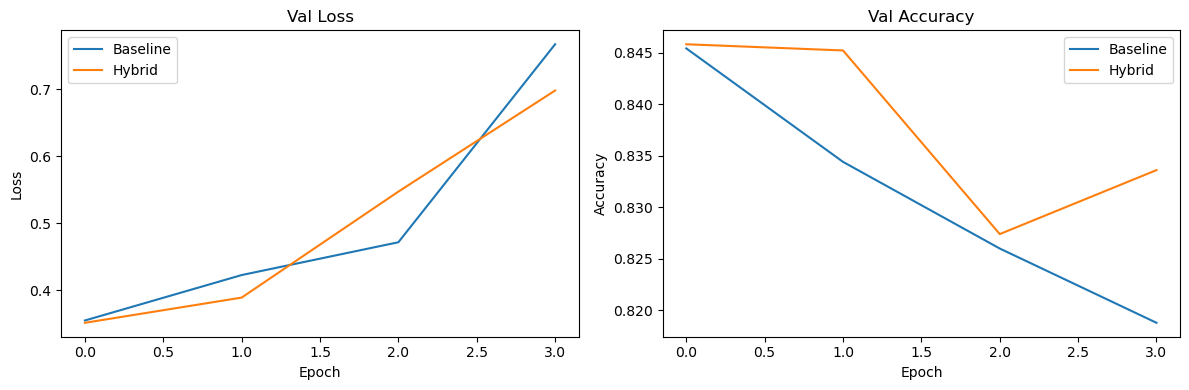

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(hist_base.history['val_loss'], label='Baseline'); plt.plot(history.history['val_loss'], label='Hybrid'); plt.title('Val Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1,2,2); plt.plot(hist_base.history['val_accuracy'], label='Baseline'); plt.plot(history.history['val_accuracy'], label='Hybrid'); plt.title('Val Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

Modelo Optimizado

Características extraídas para el conjunto de prueba.


c:\Users\Ale\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 128)   │  6,400,000 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 80, 128)   │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 80)        │          0 │ sequence_input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 80, 256)   │    263,168 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    394,240 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_input      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 262)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ features_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     33,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,099,393 (27.08 MB)

 Trainable params: 7,099,393 (27.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.7739 - loss: 0.4664 - val_accuracy: 0.8458 - val_loss: 0.3515 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.8963 - loss: 0.2650 - val_accuracy: 0.8452 - val_loss: 0.3891 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.9434 - loss: 0.1593 - val_accuracy: 0.8274 - val_loss: 0.5474 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.9754 - loss: 0.0704 - val_accuracy: 0.8336 - val_loss: 0.6984 - learning_rate: 5.0000e-04
Accuracy: 0.8379
Precision: 0.8408
Recall: 0.8336
F1-Score: 0.8372


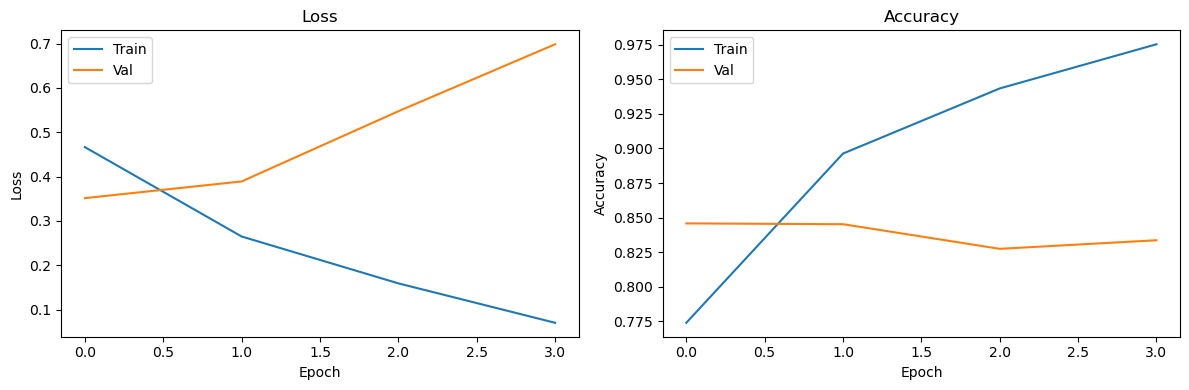

In [ ]:

#Extraer características para el conjunto de prueba 
test_features = extract_features_from_encoded(X_test)
test_features_array = np.array([[f[name] for name in feature_names] for f in test_features])
print('Características extraídas para el conjunto de prueba.')

tf.random.set_seed(42); np.random.seed(42)

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_array)
test_features_scaled = scaler.transform(test_features_array)

vocab_size = vocab_size if 'vocab_size' in globals() else 50000
embedding_dim = embedding_dim if 'embedding_dim' in globals() else 128
lstm_units = lstm_units if 'lstm_units' in globals() else 128

# Entradas
input_seq = Input(shape=(maxlen,), name='sequence_input')
input_features = Input(shape=(len(feature_names),), name='features_input')

# Encoder LSTM mejorado
x = Embedding(vocab_size, embedding_dim, input_length=maxlen, mask_zero=True)(input_seq)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
x = Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dropout(0.3)(x)

# Fusionar con features
combined = Concatenate()([x, input_features])
h = Dense(128, activation='relu')(combined)
h = Dropout(0.3)(h)
h = Dense(64, activation='relu')(h)
h = Dropout(0.3)(h)
output = Dense(1, activation='sigmoid')(h)

model = Model(inputs=[input_seq, input_features], outputs=output)
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
ckpt = ModelCheckpoint('best_hybrid.keras', monitor='val_loss', save_best_only=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Entrenamiento
history = model.fit(
    [X_train, train_features_scaled], y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, ckpt, rlrop],
    verbose=1
)

# Evaluación
y_pred_prob = model.predict([X_test, test_features_scaled], verbose=0).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()

In [27]:

tabla = pd.DataFrame([
    ["Baseline", float(acc_b),   float(pre_b),     float(rec_b),   float(f1_b)],
    ["Hybrid",  float(accuracy), float(precision), float(recall), float(f1)],
], columns=["Modelo","Accuracy","Precision","Recall","F1"])
print(tabla.to_string(index=False))



  Modelo  Accuracy  Precision  Recall       F1
Baseline   0.83940   0.829310 0.85472 0.841823
  Hybrid   0.83788   0.840797 0.83360 0.837183


### **Análisis y Resultados**

Para presentar los resultados, comparamos dos enfoques entrenados con la misma partición y configuración; un modelo base “simple” (Embedding + BiLSTM + sigmoide) y un modelo híbrido que toma el texto con BiLSTM apiladas (con dropout) y lo fusiona con un vector de features normalizadas antes de las capas densas. Las curvas de entrenamiento mostraron sobreajuste temprano, así que usamos early stopping con restauración de los mejores pesos; el mejor punto del híbrido fue en la época 0 según la val_loss.

En prueba, el baseline obtuvo **Accuracy** = 0.839, **Precision** = 0.829, **Recall** = 0.855 y **F1** = 0.842; el híbrido logró **Accuracy** = 0.838, **Precision** = 0.841, **Recall** = 0.834 y **F1** = 0.837. En la práctica, hay un empate en accuracy, con más precisión del híbrido (+0.012) y más recall del baseline (+0.021), lo que explica el F1 ligeramente superior del baseline (+0.005).

Esta comparación deja un trade-off claro, puesto que las features adicionales del híbrido parecen ayudar a reducir falsos positivos (sube la precisión), pero a costa de perder algunos verdaderos positivos (baja el recall). El baseline hace el movimiento opuesto. Por eso, si la prioridad es evitar falsos positivos, el híbrido es la mejor elección. Por otro lado, si lo más importante es capturar la mayor cantidad de positivos, el baseline rinde mejor.

Ambos modelos son competitivos y la elección depende del objetivo. Sin volver a entrenar, se puede ajustar el umbral de decisión con la validación para maximizar la métrica objetivo (por ejemplo, F1) y, si se busca más generalización, reforzar un poco la regularización (más dropout o L2) para contener el sobreajuste observado.